Грузим датасет imagenette

In [ ]:
conda install -c fastai -c pytorch fastai

In [ ]:
help(untar_data)

In [ ]:
path = untar_data(URLs.IMAGENETTE_320, dest ='./imagenette/')
path

Pipeline. На 200 эпохах accuracy на тестовом датасете 83%.

In [1]:
import torch
import torchvision
from torch import nn
from fastai import *
from fastai.vision import *
import pandas as pd

#hyper params

In [2]:
batch_size = 32
num_epoch = 200

Посмортим csv, приложенный к датасету. 

In [3]:
labels_df = pd.read_csv('./imagenette/imagenette2-320/noisy_imagenette.csv')
labels_df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02979186/n02979186_9036.JPEG,n02979186,n02979186,n02979186,n02979186,n02979186,False
1,train/n02979186/n02979186_11957.JPEG,n02979186,n02979186,n02979186,n02979186,n03000684,False
2,train/n02979186/n02979186_9715.JPEG,n02979186,n02979186,n02979186,n03417042,n03000684,False
3,train/n02979186/n02979186_21736.JPEG,n02979186,n02979186,n02979186,n02979186,n03417042,False
4,train/n02979186/ILSVRC2012_val_00046953.JPEG,n02979186,n02979186,n02979186,n02979186,n03394916,False


In [4]:
for cols in labels_df.columns:
    print(cols, ' have ', len(labels_df[cols].unique()), 'labels')

path  have  13394 labels
noisy_labels_0  have  10 labels
noisy_labels_1  have  10 labels
noisy_labels_5  have  10 labels
noisy_labels_25  have  10 labels
noisy_labels_50  have  10 labels
is_valid  have  2 labels


In [5]:
from torchvision import transforms, datasets

train_transform = transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

trainset = datasets.ImageFolder(root='./imagenette/imagenette2-320/train/', transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
testset = datasets.ImageFolder(root='./imagenette/imagenette2-320/val/', transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

/opt/conda/lib/python3.6/site-packages/torchvision/transforms/transforms.py:704: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


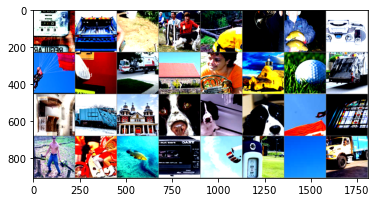

tensor([7, 6, 0, 1, 3, 5, 0, 2, 9, 7, 6, 4, 5, 4, 8, 6, 4, 6, 4, 1, 1, 1, 9, 4,
        3, 5, 0, 2, 9, 7, 7, 6])


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
print(labels)


In [7]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            # 224x224x64
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer2 = nn.Sequential(
            # 112x112x128
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer3 = nn.Sequential(
            # 56x56x256
            nn.Conv2d(128,256, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
#             nn.Conv2d(256,256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer4 = nn.Sequential(
            # 28x28x512
            nn.Conv2d(256,512, kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.layer5 = nn.Sequential(
            # 14x14x512
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )
        self.dense_layer = nn.Sequential(
            # 7x7x512 -> 1x1x4096 -> 1x1x1000 -> softmax
            nn.Linear(in_features=7*7*512, out_features = 128),
            nn.Dropout(.5),
            nn.ReLU(),
#             nn.Linear(in_features=256, out_features=128),
#             nn.Dropout(.5),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=10),
#             nn.ReLU(),
#             nn.Softmax(dim=1)
#             nn.CrossEntropyLoss()
            )
    def forward(self, input):
        x = self.layer1(input)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
#         print(x.shape)
        out = self.dense_layer(x)
#         print(out.shape)
        return out

In [8]:
model = VGG()
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
# criterion = nn.Softmax(dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

model.to(device)

cuda:0


VGG(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
for epoch in range(num_epoch):  # loop over the dataset multiple times
    
#     model.train()
    
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         print(data[1])
        inputs, labels = data[0].to(device), data[1].to(device)
#         print(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
#         print('Loss: ', loss)
        loss.backward()
        optimizer.step()

    #Accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            outputs = outputs.cuda()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epoch, loss, correct/total))
#     print('Epoch: ', epoch, ' loss:', loss[0], ' accuracy_val: ', accuracy(outputs, labels))

       
        # print statistics
#         running_loss += loss.item()
#         if i % 10 == 9:    # print every 2000 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, loss)) #running_loss / 2000
#             print('labels:',  labels)
#             print('outputs: ', outputs)
#             running_loss = 0.0

print('Finished Training')

Epoch 1/200, Loss: 0.131, Accuracy: 0.180
Epoch 2/200, Loss: 2.226, Accuracy: 0.283
